# 4square_channel

## 5. 4square_channel.png Four square = imagery, surface, bed&surface, change

### Datapaper plots

1. field_location.png Modis moa Inset map, ant in corner, icestreams scale, square of common border, include flow route,
2. geophysics_overview.png Map of all data presented
3. historic_channel.png Historic landsat images
4. thickness_surfacecolour.png Profile depth
6. 3D view of channel
7. radarlines 
8. channel_meander.png meander
11. ApRES include stress
9. Icesat1/REMA
10. Icesat2


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import glob
import os
import sys
import time
import datetime as dt
import pandas as pd
import geopandas as gpd
import scipy as sp
from scipy import signal
from tqdm.notebook import tqdm
import rasterio as rio
from shapely.geometry import Point, LineString, Polygon, MultiPoint
import fiona
from shapely.ops import nearest_points
from rasterio.windows import Window
import string

In [2]:
xmin, xmax, ymin, ymax = -382700, -374781.9, -734075.1, -721770.2

In [3]:
#load REMA dem
with rio.open('/Volumes/arc_02/whitefar/DATA/REMOTE_SENSING/REMA_STRIPES/SETSM_WV01_20161109_1020010058134D00_10200100576C9100_seg1_2m_v1.0_dem.tif') as image:
    extent_REMA = [image.bounds[0],image.bounds[2],image.bounds[1],image.bounds[3]]
    im_REMA = image.read(1)
    
x = np.linspace(extent_REMA[0],extent_REMA[1],im_REMA.shape[1]).astype('int')
y = np.linspace(extent_REMA[3],extent_REMA[2],im_REMA.shape[0]).astype('int')

x_i = np.argwhere((x>xmin) & (x< xmax)).flatten()[0]
x_j = np.argwhere((x>xmin) & (x< xmax)).flatten()[-1]
y_i = np.argwhere((y>ymin) & (y< ymax)).flatten()[0]
y_j = np.argwhere((y>ymin) & (y< ymax)).flatten()[-1]

x_c = np.linspace(extent_REMA[0],extent_REMA[1],im_REMA.shape[1]).astype('int')[x_i:x_j]
y_c = np.linspace(extent_REMA[3],extent_REMA[2],im_REMA.shape[0]).astype('int')[y_i:y_j]

xv_REMA, yv_REMA = np.meshgrid(x_c, y_c)

im_REMA_d = im_REMA[y_i:y_j,x_i:x_j]
im_REMA_d[im_REMA_d==-99.99] = np.nan
im_REMA_c = im_REMA_d

In [9]:
im_REMA[im_REMA!=-9999.0].mean()

67.36358

In [4]:
# Load modis moa
# with rio.open('/Volumes/arc_02/REMOTE_SENSING/Quantarctica3/SatelliteImagery/MODIS/MODIS_Mosaic_siplecoast.tif') as image:
#     extent_moa = [image.bounds[0],image.bounds[2],image.bounds[1],image.bounds[3]]
#     im_moa = image.read(1)
#     window=Window(0, 0, 10000, 10000)
#crop the moa image to channel area
#gdal_translate -projwin -382700.0 -721770.2 -374781.9 -734075.1 -of GTiff /Volumes/arc_02/REMOTE_SENSING/Quantarctica3/Glaciology/MOA/moa125_2009_hp1_v1.1.tif /Volumes/arc_02/REMOTE_SENSING/Quantarctica3/Glaciology/MOA/moa_cropped_channel.tif
with rio.open('/Volumes/arc_02/REMOTE_SENSING/Quantarctica3/Glaciology/MOA/moa_cropped_channel.tif') as image:
    extent_moa = [image.bounds[0],image.bounds[2],image.bounds[1],image.bounds[3]]
    im_moa = image.read(1)

In [5]:
extent_moa

[-382700.0, -374825.0, -733925.0, -721675.0]

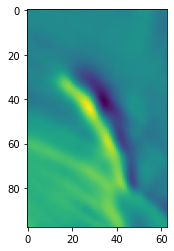

In [6]:
plt.imshow(im_moa)
plt.

In [7]:
#load REMA diff
nid1 = 159202
nid2 = 131226
df = gpd.read_file('/Volumes/arc_02/whitefar/DATA/REMOTE_SENSING/REMA_STRIPES/REMA_Strip_Index_Rel1/REMA_Strip_Index_Rel1.shp')
path = f"/Volumes/arc_02/whitefar/DATA/REMOTE_SENSING/REMA_STRIPES/DIFFERENCES/REMA_{nid1}-{nid2}_diff.tif"
# /Volumes/arc_02/whitefar/DATA/REMOTE_SENSING/REMA_STRIPES/DIFFERENCES/REMA_159202-131226_diff.tif
f = df.loc[nid1].acquisitio
t =df.loc[nid2].acquisitio
duration = (pd.to_datetime(t)-pd.to_datetime(f)).days/365.25
with rio.open(path) as image:
    im_REMAdiff = image.read(1)
    im_REMAdiff[im_REMAdiff==-9999] = np.nan
    im_REMAdiff = im_REMAdiff / duration
    extent_REMAdiff = [image.bounds[0],image.bounds[2],image.bounds[1],image.bounds[3]]

In [8]:
# Load ice base interpolated from radar results
direc = '/Users/home/whitefar/DATA/FIELD_ANT_19/POST_FIELD/RADAR_MAP/interpolatedgrid_allchan'

xv = np.load(direc + 'x_grid' +'.npy')
yv = np.load(direc + 'y_grid' +'.npy')
thickness_interpolated = np.load(direc +'ice_thickness'+'.npy')
extent_l2l = np.load(direc +'extent.npy')
ice_base = np.load(direc +'_ice_base.npy')
ice_base_smooth = sp.ndimage.gaussian_filter(ice_base, sigma=30, order=0)

In [9]:
gpr = gpd.read_file('/Volumes/arc_04/FIELD_DATA/K8621920/RES/PROCESSED_LINES/picked_bed.shp')
gpr = gpr[gpr.camp=='KIS2'].copy()
cross_channel_lines = ['line7p75','line7p5','line7p25','line7', 'line6','line5','lineAPREScross','line4','line3','line2','line1','line0','line8']
for line_name in gpr.line_name.unique():
    if line_name not in cross_channel_lines:
        i_names = gpr[gpr.line_name == line_name].index
        gpr.drop(i_names,inplace=True)

In [10]:
#smooth REMA dem for contours
im_REMA_c_smoo = sp.ndimage.gaussian_filter(im_REMA_c, sigma=20, order=0)
del im_REMA_d,im_REMA_c

In [11]:
# # get icesat2 diff lines
# import sys
# sys.path.append('/Users/home/whitefar/DATA/code/REMOTE_SENSING/ICESAT/')
# from cross_channel import icesat_dataset
# ds = icesat_dataset("/Volumes/arc_02/REMOTE_SENSING/ICESAT2/ATLAS/ATLXI/ds_subset_kamb_20201111.nc")
# ds.getdata_dhdt(cycle_number_from=3,cycle_number_till=8)
# ds.dadh.query(f'x>{xmin} & x<{xmax} & y<{ymax} & y>{ymin}',inplace=True)

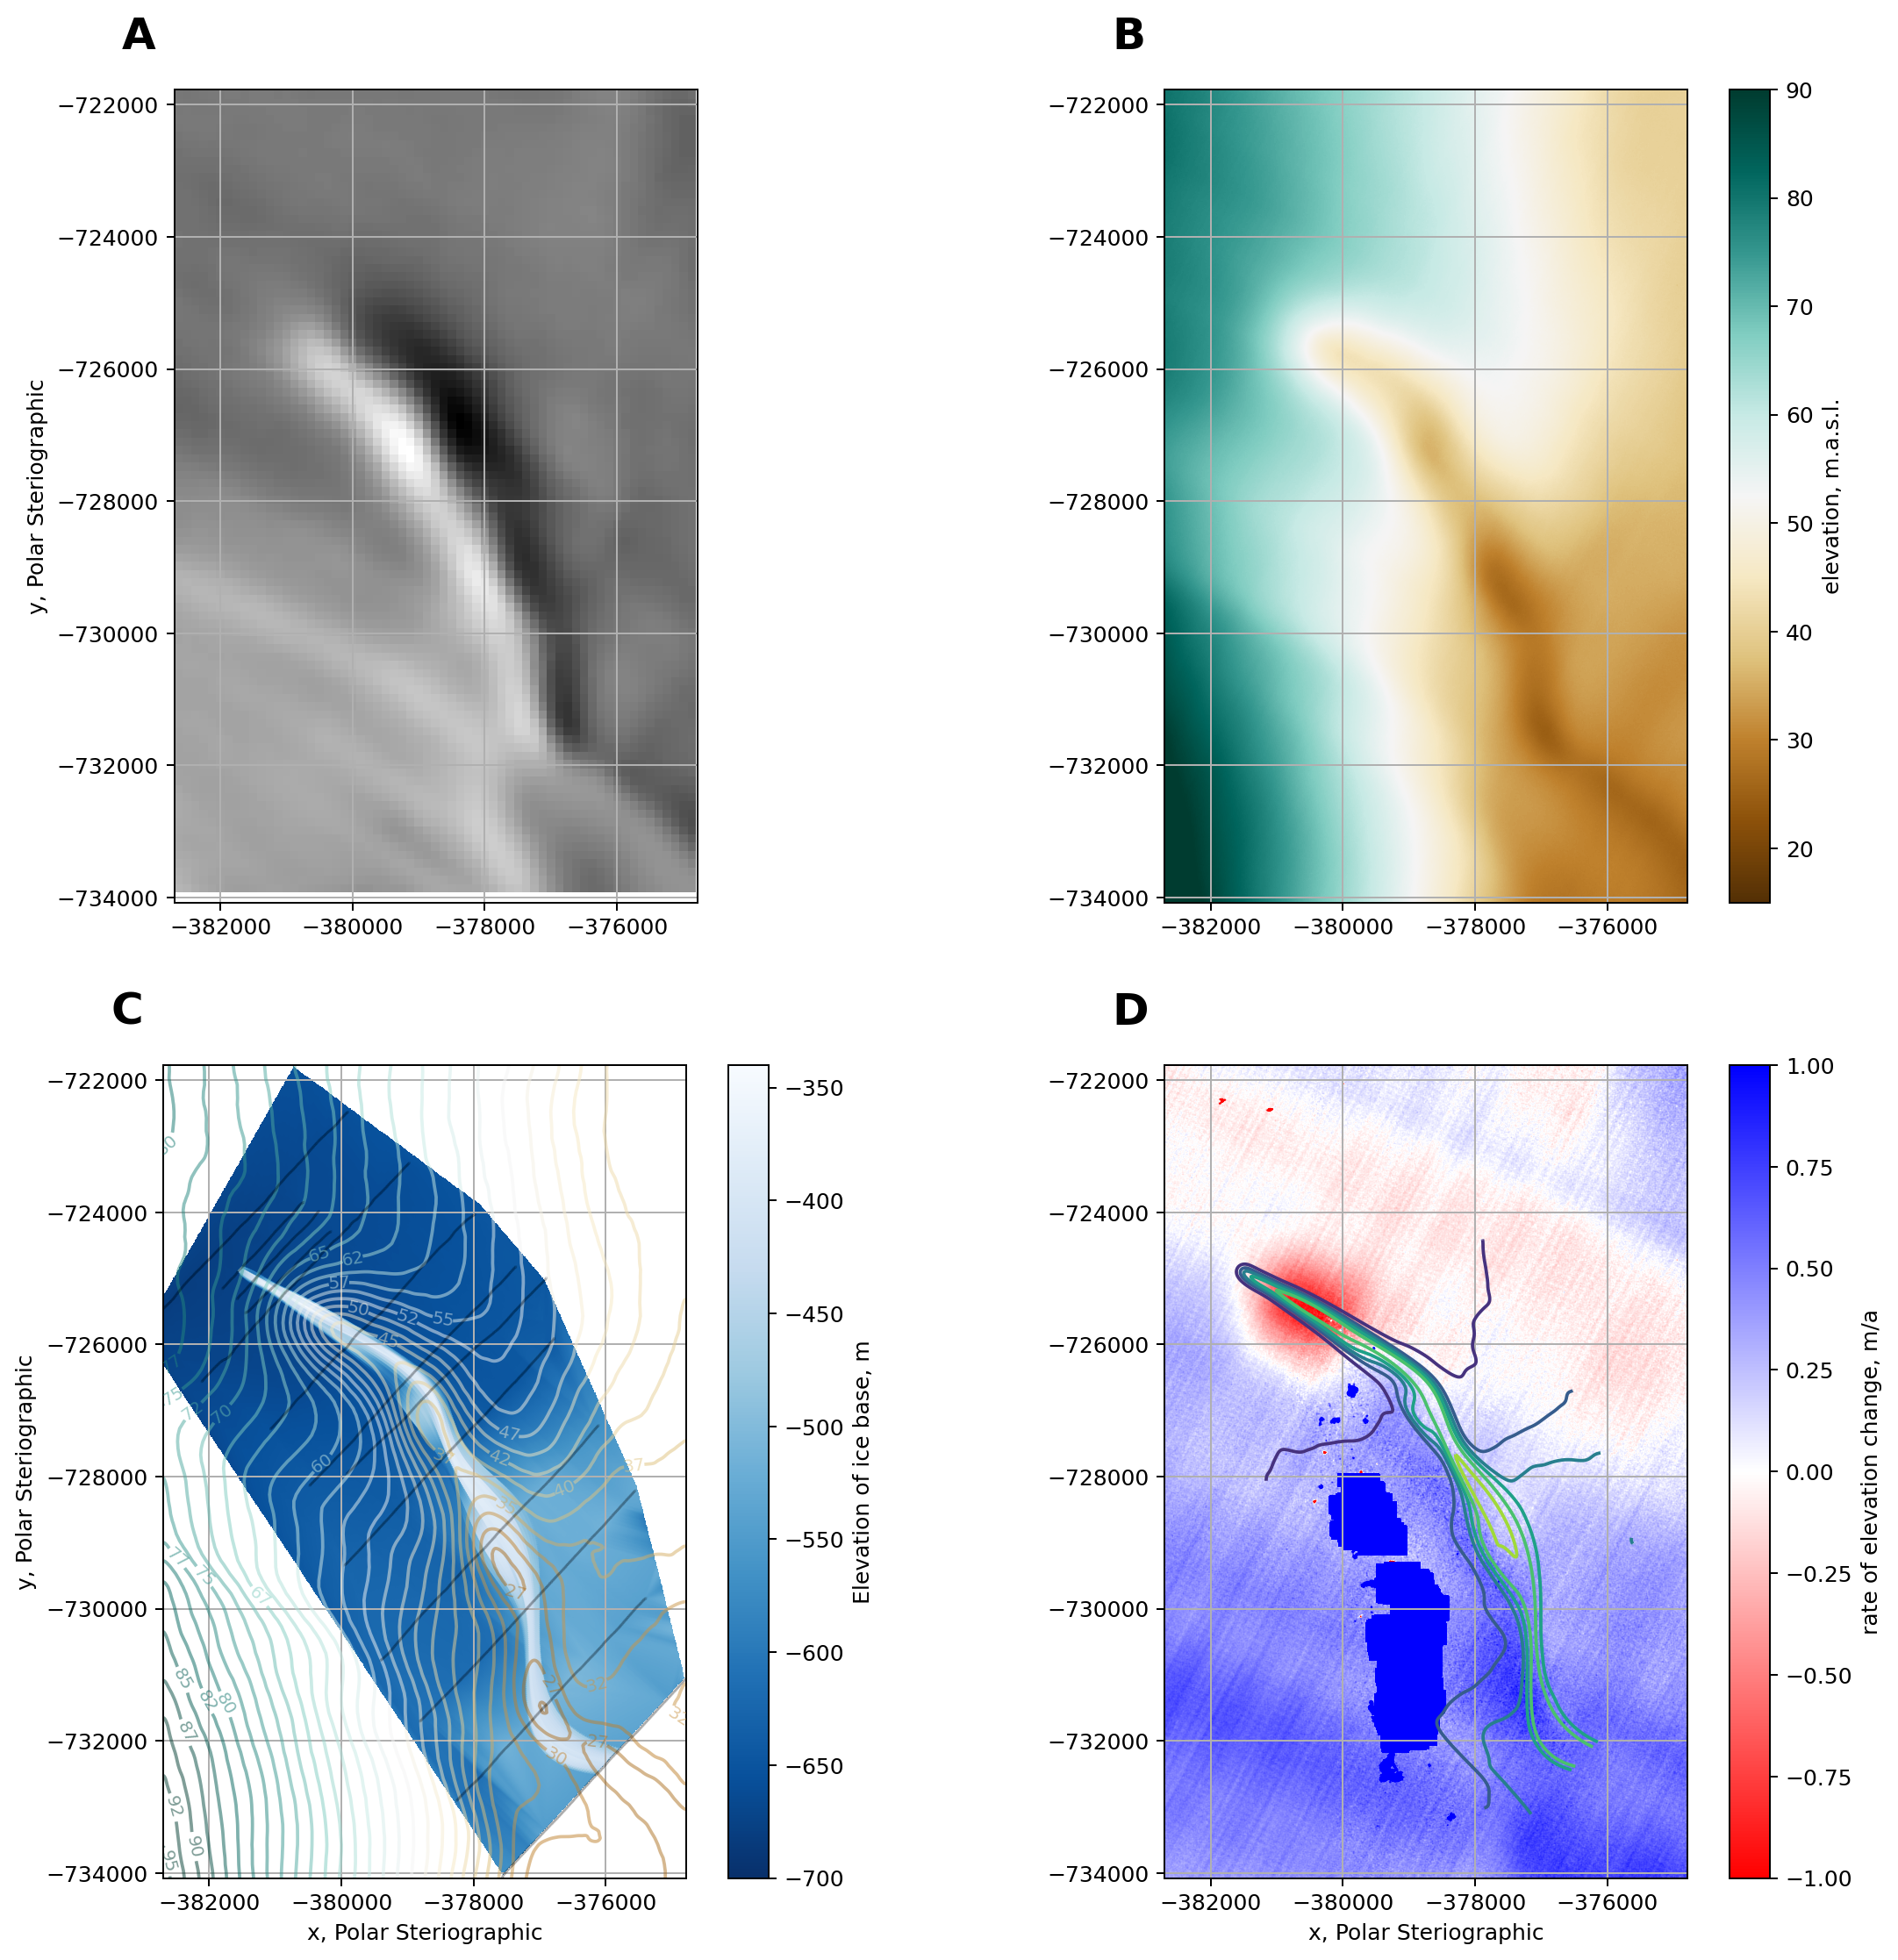

In [12]:
fig, ax = plt.subplots(2,2, dpi=180,figsize=(15,15))

#imagery
aa = ax[0,0].imshow(im_moa,extent=extent_moa, cmap='gist_gray')
ax[0,0].grid()
ax[0,0].set_xlim([xmin,xmax])
ax[0,0].set_ylim([ymin,ymax])
ax[0,0].set_ylabel('y, Polar Steriographic')
# cbb = fig.colorbar(aa,ax=ax[0,0])
# # ax[0,0].text(-0.1, 1.1, 'A', transform=ax[0,0].transAxes, 
# #             size=20, weight='bold')
# #

#surface
a1 = ax[0,1].imshow(im_REMA,extent=extent_REMA,vmin=15,vmax=90, cmap='BrBG')
ax[0,1].grid()
ax[0,1].set_xlim([xmin,xmax])
ax[0,1].set_ylim([ymin,ymax])
# ax[0,1].text(-0.1, 1.1, 'B', transform=ax[0,0].transAxes, 
#             size=20, weight='bold')

cb1 = fig.colorbar(a1,ax=ax[0,1])
cb1.set_label('elevation, m.a.s.l.')
#

#base with surface contours
samp = 50
ax[1,0].plot(gpr.x,gpr.y,'k.',label='radar profiles',markersize=0.025)
CS =  ax[1,0].contour(xv_REMA[::samp],yv_REMA[::samp],im_REMA_c_smoo[::samp],
                      30,vmin=15,vmax=90, cmap='BrBG',alpha=0.5)
ax[1,0].clabel(CS, inline=1, fontsize=8, fmt='%i')

im3 = ax[1,0].imshow(ice_base,extent=extent_l2l,cmap='Blues_r',vmin=-700,vmax=-340)


ax[1,0].grid()
ax[1,0].set_xlim([xmin,xmax])
ax[1,0].set_ylim([ymin,ymax])

cb3 = fig.colorbar(im3,ax=ax[1,0])
cb3.set_label('Elevation of ice base, m')
ax[1,0].set_xlabel('x, Polar Steriographic')
ax[1,0].set_ylabel('y, Polar Steriographic')
#

#rate of change of surf
CS4 =  ax[1,1].contour(xv[:,500:],yv[:,500:],ice_base_smooth[:,500:],np.arange(-700,-300,50))
# ax[1,1].clabel(CS4, inline=1, fontsize=8, fmt='%i')

im4 = ax[1,1].imshow(-im_REMAdiff,extent=extent_REMAdiff, vmin=-1,vmax=1,cmap='bwr_r')
# ax[1,1].scatter(ds.dadh.x,ds.dadh.y,c=ds.dadh.dhdt,cmap='bwr_r',vmin=-0.8, vmax=1)
ax[1,1].grid()
ax[1,1].set_xlim([xmin,xmax])
ax[1,1].set_ylim([ymin,ymax])

cb4 = fig.colorbar(im4,ax=ax[1,1])
cb4.set_label('rate of elevation change, m/a')
ax[1,1].set_xlabel('x, Polar Steriographic')


axs = ax.flat

for n, a in enumerate(axs):
    a.text(-0.1, 1.05, string.ascii_uppercase[n], transform=a.transAxes, 
            size=20, weight='bold')

plt.savefig('/Users/home/whitefar/ASSIGNMENTS-PUBLICATIONS-TALKS/channel_data_writeup/PLOTS/4square_channel.png')

##############################

plt.show()
#